# Adam

Adam 是一个组合了动量法和 RMSProp 的优化算法 [1]。下面我们来介绍 Adam 算法。


## Adam 算法

Adam 算法使用了动量变量 $\boldsymbol{v}$ 和 RMSProp 中小批量随机梯度按元素平方的指数加权移动平均变量 $\boldsymbol{s}$，并将它们中每个元素初始化为 0。在每次迭代中，时刻 $t$ 的小批量随机梯度记作 $\boldsymbol{g}_t$。


和动量法类似，给定超参数 $\beta_1$ 且满足 $0 \leq \beta_1 < 1$（算法作者建议设为 0.9），将小批量随机梯度的指数加权移动平均记作动量变量 $\boldsymbol{v}$，并将它在时刻 $t$ 的值记作 $\boldsymbol{v}_t$：

$$\boldsymbol{v}_t \leftarrow \beta_1 \boldsymbol{v}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t. $$

和 RMSProp 中一样，给定超参数 $\beta_2$ 且满足 $0 \leq \beta_2 < 1$（算法作者建议设为 0.999），
将小批量随机梯度按元素平方后做指数加权移动平均得到 $\boldsymbol{s}$，并将它在时刻 $t$ 的值记作 $\boldsymbol{s}_t$：

$$\boldsymbol{s}_t \leftarrow \beta_2 \boldsymbol{s}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

由于我们将 $\boldsymbol{v}$ 和 $\boldsymbol{s}$ 中的元素都初始化为 0，
在时刻 $t$ 我们得到 $\boldsymbol{v}_t =  (1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} \boldsymbol{g}_i$。将过去各时刻小批量随机梯度的权值相加，得到 $(1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} = 1 - \beta_1^t$。需要注意的是，当 $t$ 较小时，过去各时刻小批量随机梯度权值之和会较小。例如当 $\beta_1 = 0.9$ 时，$\boldsymbol{v}_1 = 0.1\boldsymbol{g}_1$。为了消除这样的影响，对于任意时刻 $t$，我们可以将 $\boldsymbol{v}_t$ 再除以 $1 - \beta_1^t$，从而使得过去各时刻小批量随机梯度权值之和为 1。这也叫做偏差修正。在 Adam 算法中，我们对变量 $\boldsymbol{v}$ 和 $\boldsymbol{s}$ 均作偏差修正：

$$\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_1^t}, $$

$$\hat{\boldsymbol{s}}_t \leftarrow \frac{\boldsymbol{s}_t}{1 - \beta_2^t}. $$


接下来，Adam 算法使用以上偏差修正后的变量 $\hat{\boldsymbol{v}}_t$ 和 $\hat{\boldsymbol{s}}_t$，将模型参数中每个元素的学习率通过按元素运算重新调整：

$$\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{v}}_t}{\sqrt{\hat{\boldsymbol{s}}_t + \epsilon}},$$

其中 $\eta$ 是初始学习率且 $\eta > 0$，$\epsilon$ 是为了维持数值稳定性而添加的常数，例如 $10^{-8}$。和 Adagrad、RMSProp 以及 Adadelta 一样，目标函数自变量中每个元素都分别拥有自己的学习率。

最后，时刻 $t$ 的自变量 $\boldsymbol{x}_t$ 的迭代步骤与小批量随机梯度下降类似：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'. $$


## Adam 的实现


Adam 的实现很简单。我们只需要把上面的数学公式翻译成代码。

In [1]:
def adam(params, vs, sqrs, lr, batch_size, t):
    beta1 = 0.9
    beta2 = 0.999
    eps_stable = 1e-8
    for param, v, sqr in zip(params, vs, sqrs):      
        g = param.grad / batch_size
        v[:] = beta1 * v + (1 - beta1) * g
        sqr[:] = beta2 * sqr + (1 - beta2) * g.square()
        v_bias_corr = v / (1 - beta1 ** t)
        sqr_bias_corr = sqr / (1 - beta2 ** t)    
        param[:] = param - lr * v_bias_corr / (
            sqr_bias_corr.sqrt() + eps_stable)  

## 实验

首先，导入实验所需的包或模块。

In [2]:
import sys
sys.path.append('..')
import gluonbook as gb
from mxnet import autograd, nd
import numpy as np

实验中，我们依然以线性回归为例。设数据集的样本数为 1000，我们使用权重 `w` 为 [2, -3.4]，偏差 `b` 为 4.2 的线性回归模型来生成数据集。该模型的平方损失函数即所需优化的目标函数，模型参数即目标函数自变量。

我们把算法中变量 $\boldsymbol{v}$ 和 $\boldsymbol{s}$ 初始化为和模型参数形状相同的零张量。

In [3]:
# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

# 初始化模型参数。
def init_params():
    w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    vs = []
    sqrs = []
    for param in params:
        param.attach_grad()
        # 把算法中基于指数加权移动平均的变量初始化为和参数形状相同的零张量。
        vs.append(param.zeros_like())
        sqrs.append(param.zeros_like())
    return params, vs, sqrs

优化函数 `optimize` 与 [“Adagrad”](adagrad.md) 一节中的类似。

In [4]:
net = gb.linreg
loss = gb.squared_loss

def optimize(batch_size, lr, num_epochs, log_interval):
    [w, b], vs, sqrs = init_params()
    ls = [loss(net(features, w, b), labels).mean().asnumpy()]
    t = 0
    for epoch in range(1, num_epochs + 1):
        for batch_i, (X, y) in enumerate(
            gb.data_iter(batch_size, features, labels)):
            with autograd.record():
                l = loss(net(X, w, b), y)
            l.backward()
            # 必须在调用 Adam 前。
            t += 1
            adam([w, b], vs, sqrs, lr, batch_size, t)
            if batch_i * batch_size % log_interval == 0:
                ls.append(loss(net(features, w, b), labels).mean().asnumpy())
    print('w:', w, '\nb:', b, '\n')
    es = np.linspace(0, num_epochs, len(ls), endpoint=True)
    gb.semilogy(es, ls, 'epoch', 'loss')

最终，优化所得的模型参数值与它们的真实值较接近。

w: 
[[ 1.99964905]
 [-3.39966011]]
<NDArray 2x1 @cpu(0)> 
b: 
[ 4.19986629]
<NDArray 1 @cpu(0)> 



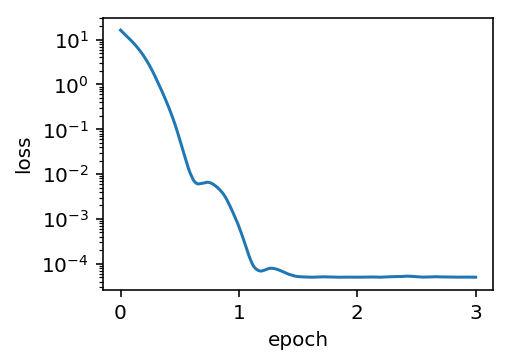

In [5]:
optimize(batch_size=10, lr=0.1, num_epochs=3, log_interval=10)

## 小结

* Adam 组合了动量法和 RMSProp。
* Adam 使用了偏差修正。


## 练习

* 使用其他初始学习率，观察并分析实验结果。


## 扫码直达 [ 讨论区 ](https://discuss.gluon.ai/t/topic/2279)


![](../img/qr_adam.svg)

## 参考文献

[1] Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.